<a href="https://colab.research.google.com/github/rodzhttp/Pyspark1/blob/main/An%C3%A1lise_de_Voos_e_Atrasos_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**< Análise de Voos e Atrasos >**

### **Visão Geral do Projeto**
Para este projeto, realizei uma análise exploratória em um grande volume de dados de voos dos EUA, utilizando um dataset público (Kaggle) com quase 6 milhões de registros. O maior desafio foi o tamanho do conjunto de dados, que o torna inviável para processamento em ferramentas tradicionais como o Pandas. Para isso, a solução adotada foi usar o Apache PySpark, que permitiu a manipulação do conjunto de dados.

Principais Análises e Descobertas
Desempenho das Companhias Aéreas: Criei um ranking de pontualidade que revelou quais companhias tiveram as maiores médias de atraso e quais se destacaram por chegar adiantadas.

Padrões de Atraso ao Longo do Ano: A análise dos meses do ano confirmou que períodos de alta temporada, como as férias de verão (junho), são mais propensos a atrasos, enquanto meses de menor movimento, como setembro e outubro, apresentaram o melhor desempenho.

Padrões Semanais: A análise revelou quais dias da semana são mais propensos a atrasos, com a sexta-feira se mostrando um dos piores dias para viajar, enquanto o sábado se destacou como um dos mais pontuais.

Visualização de Dados: Desenvolvi gráficos de barras com Matplotlib para apresentar os padrões de atraso de forma clara, facilitando a comparação entre meses e companhias aéreas.

Tecnologias e Habilidades

Processamento de Big Data: Apache Spark (PySpark)
Análise de Dados: Spark DataFrame API, agregações e joins.
Linguagem: Python
Visualização de Dados: Matplotlib
Ambiente de Desenvolvimento: Google Colab

In [ ]:
# Instala as bibliotecas necessárias
!pip install pyspark findspark

# Configura o ambiente para encontrar o Spark
import findspark
from google.colab import drive
findspark.init()

# Inicia a "Sessão Spark", que é o nosso motor para processar os dados
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("AnaliseVoos").getOrCreate()

print("✅ Sessão Spark iniciada com sucesso!")

✅ Sessão Spark iniciada com sucesso!


In [58]:
# O caminho para a pasta que contém seus arquivos
caminho_base = '/content/drive/My Drive/Colab Notebooks/Pyspark project/'

# Caminho completo para cada arquivo
caminho_flights = caminho_base + 'flights.csv'
caminho_airlines = caminho_base + 'airlines.csv'
caminho_airports = caminho_base + 'airports.csv'

# Lendo os arquivos para DataFrames
df_flights = spark.read.csv(caminho_flights, header=True, inferSchema=True)
df_airlines = spark.read.csv(caminho_airlines, header=True, inferSchema=True)
df_airports = spark.read.csv(caminho_airports, header=True, inferSchema=True)

print("✅ Sessão Spark iniciada com sucesso!")

✅ Sessão Spark iniciada com sucesso!


In [54]:
from pyspark.sql.functions import avg, desc, round, col, when, concat, lit

# 1. Calcula a média de atraso
media_atrasos = df_flights.groupBy("AIRLINE") \
    .agg(
        round(avg("ARRIVAL_DELAY"), 2).alias("media_atraso_chegada")
    )

# 2. Junta com a tabela de companhias
resultado_atrasos = media_atrasos.join(
        df_airlines,
        media_atrasos.AIRLINE == df_airlines.IATA_CODE
    )

# 3. Formata a coluna de resultado condicionalmente
resultado_formatado = resultado_atrasos.withColumn("Resultado",
    when(col("media_atraso_chegada") >= 0,
         concat(col("media_atraso_chegada").cast("string"), lit(" minutos"))
    ).otherwise(
         col("media_atraso_chegada").cast("string")
    )
)

# 4. Ordena pelo valor numérico ANTES de selecionar as colunas finais
resultado_ordenado = resultado_formatado.orderBy(desc("media_atraso_chegada"))

# 5. Seleciona as colunas para exibição e mostra o resultado
print("Média de Atrasos na Chegada por Companhia Aérea:")
resultado_ordenado.select(
    df_airlines.AIRLINE.alias("NOME_DA_COMPANHIA"),
    "Resultado"
).show()
print("obs: Valores negativos significam que, na média, os voos chegaram adiantados")

Média de Atrasos na Chegada por Companhia Aérea:
+--------------------+-------------+
|   NOME_DA_COMPANHIA|    Resultado|
+--------------------+-------------+
|    Spirit Air Lines|14.47 minutos|
|Frontier Airlines...| 12.5 minutos|
|     JetBlue Airways| 6.68 minutos|
|Atlantic Southeas...| 6.59 minutos|
|American Eagle Ai...| 6.46 minutos|
|Skywest Airlines ...| 5.85 minutos|
|United Air Lines ...| 5.43 minutos|
|      Virgin America| 4.74 minutos|
|Southwest Airline...| 4.37 minutos|
|     US Airways Inc.| 3.71 minutos|
|American Airlines...| 3.45 minutos|
|Hawaiian Airlines...| 2.02 minutos|
|Delta Air Lines Inc.| 0.19 minutos|
|Alaska Airlines Inc.|        -0.98|
+--------------------+-------------+

obs: Valores negativos significam que, na média, os voos chegaram adiantados


In [53]:
from pyspark.sql.functions import avg, round, concat, lit, lpad, col, when

print("Média de Atraso na Chegada por Mês (formatado):")

# 1. Cria a coluna 'ANO_MES'
df_com_data = df_flights.withColumn("ANO_MES",
    concat(col("YEAR"), lit("-"), lpad(col("MONTH"), 2, "0"))
)

# 2. Calcula a média de atraso
atraso_calculado = df_com_data.groupBy("ANO_MES") \
    .agg(round(avg("ARRIVAL_DELAY"), 2).alias("media_de_atraso"))

# 3. Formata a coluna de resultado condicionalmente
resultado_final = atraso_calculado.withColumn("Resultado",
    when(col("media_de_atraso") >= 0,
         concat(col("media_de_atraso").cast("string"), lit(" minutos"))
    ).otherwise(
         col("media_de_atraso").cast("string") # Para valores negativos, mostra só o número
    )
).orderBy("ANO_MES")

resultado_final.select("ANO_MES", "Resultado").show()
print("obs: Valores negativos significam que, na média, os voos chegaram adiantados")

Média de Atraso na Chegada por Mês (formatado):
+-------+------------+
|ANO_MES|   Resultado|
+-------+------------+
|2015-01|5.81 minutos|
|2015-02|8.32 minutos|
|2015-03|4.92 minutos|
|2015-04|3.16 minutos|
|2015-05|4.49 minutos|
|2015-06| 9.6 minutos|
|2015-07|6.43 minutos|
|2015-08|4.61 minutos|
|2015-09|       -0.77|
|2015-10|       -0.78|
|2015-11| 1.1 minutos|
|2015-12|6.09 minutos|
+-------+------------+

obs: Valores negativos significam que, na média, os voos chegaram adiantados


In [55]:
from pyspark.sql.functions import avg, round, col, when, concat, lit, asc

# 1. Calcula a média de atraso por dia da semana
atraso_por_dia = df_flights.groupBy("DAY_OF_WEEK") \
    .agg(round(avg("ARRIVAL_DELAY"), 2).alias("media_atraso"))

# 2. Mapeia o número do dia para o nome correspondente
mapeamento_dia = atraso_por_dia.withColumn("Dia da Semana",
    when(col("DAY_OF_WEEK") == 1, "Domingo")
    .when(col("DAY_OF_WEEK") == 2, "Segunda-feira")
    .when(col("DAY_OF_WEEK") == 3, "Terça-feira")
    .when(col("DAY_OF_WEEK") == 4, "Quarta-feira")
    .when(col("DAY_OF_WEEK") == 5, "Quinta-feira")
    .when(col("DAY_OF_WEEK") == 6, "Sexta-feira")
    .otherwise("Sábado")
)

# 3. Formata a coluna de resultado condicionalmente
resultado_formatado = mapeamento_dia.withColumn("Resultado",
    when(col("media_atraso") >= 0,
         concat(col("media_atraso").cast("string"), lit(" minutos"))
    ).otherwise(
         col("media_atraso").cast("string")
    )
)

# 4. Ordena pelo menor atraso (melhor dia primeiro) e exibe
print("Média de Atraso por Dia da Semana (ordenado do melhor para o pior):")
resultado_formatado.orderBy(asc("media_atraso")).select("Dia da Semana", "Resultado").show()

Média de Atraso por Dia da Semana (ordenado do melhor para o pior):
+-------------+------------+
|Dia da Semana|   Resultado|
+-------------+------------+
|  Sexta-feira|1.85 minutos|
|  Terça-feira|3.85 minutos|
|       Sábado|3.96 minutos|
|Segunda-feira|4.25 minutos|
| Quinta-feira|4.76 minutos|
| Quarta-feira|5.67 minutos|
|      Domingo| 6.0 minutos|
+-------------+------------+



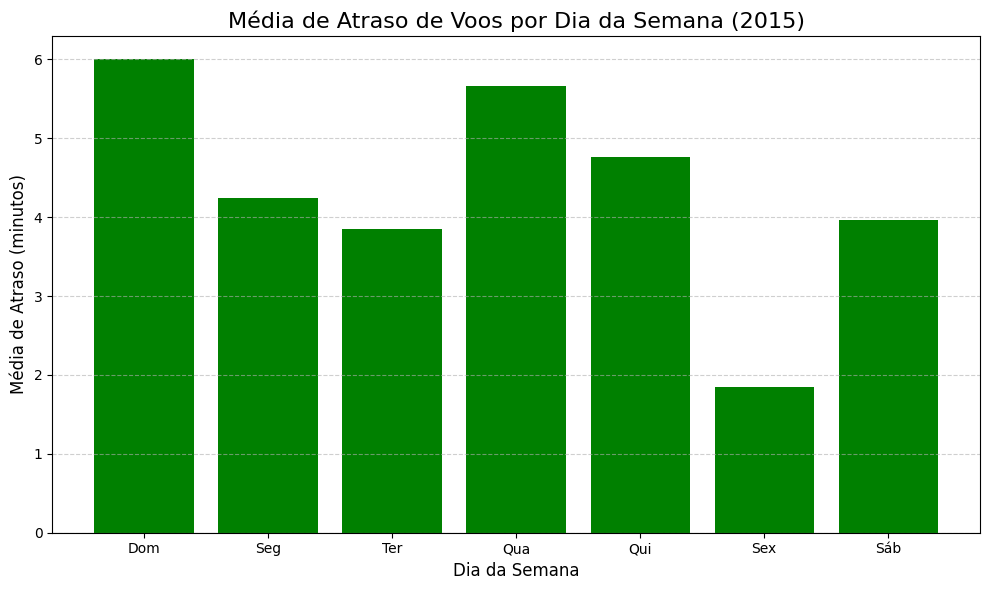

In [70]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, round, col, when

# 1. Agrega os dados de atraso por dia da semana no PySpark
atraso_por_dia_agg = df_flights.groupBy("DAY_OF_WEEK") \
    .agg(round(avg("ARRIVAL_DELAY"), 2).alias("media_atraso"))

# 2. Mapeia os números para nomes de dias (abreviados para o gráfico)
mapeamento_dia = atraso_por_dia_agg.withColumn("Dia",
    when(col("DAY_OF_WEEK") == 1, "Dom")
    .when(col("DAY_OF_WEEK") == 2, "Seg")
    .when(col("DAY_OF_WEEK") == 3, "Ter")
    .when(col("DAY_OF_WEEK") == 4, "Qua")
    .when(col("DAY_OF_WEEK") == 5, "Qui")
    .when(col("DAY_OF_WEEK") == 6, "Sex")
    .otherwise("Sáb")
).orderBy("DAY_OF_WEEK")

# 3. Converte o resultado para um DataFrame do Pandas
atraso_dia_pandas = mapeamento_dia.toPandas()

# 4. Gera o gráfico com Matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(atraso_dia_pandas['Dia'], atraso_dia_pandas['media_atraso'], color='green') # <-- COR ALTERADA AQUI

# Adiciona uma linha no zero para referência
plt.axhline(0, color='grey', linewidth=0.8)

# Adiciona títulos e rótulos
plt.title('Média de Atraso de Voos por Dia da Semana (2015)', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Média de Atraso (minutos)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Salva o gráfico em um arquivo
plt.savefig('atraso_por_dia_verde.png')

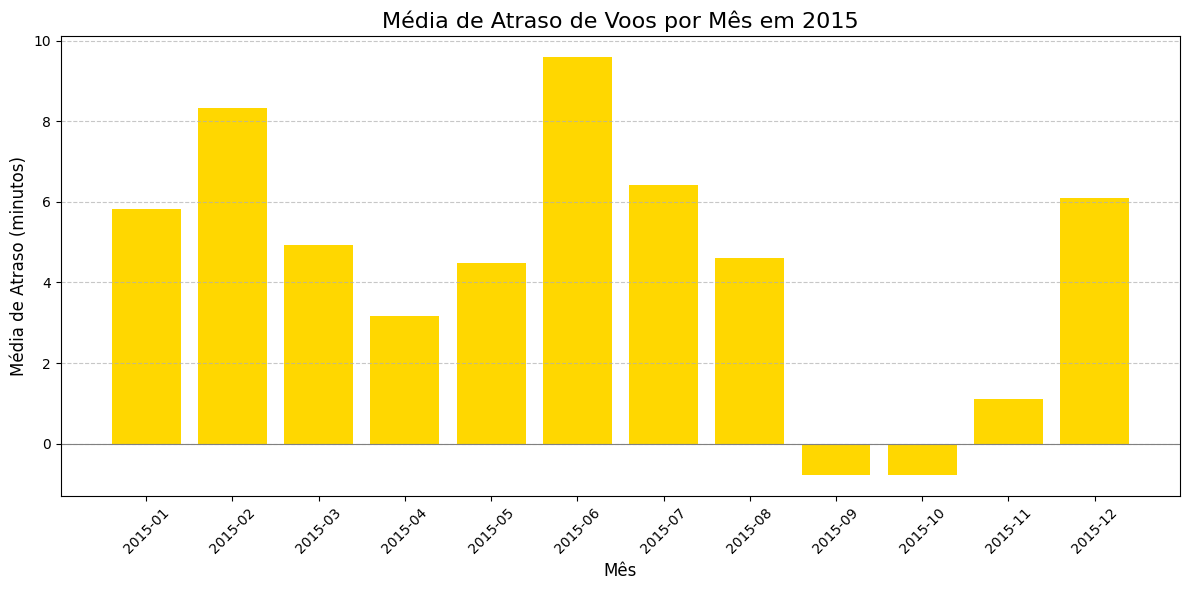

In [69]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, round, concat, lit, lpad, col

# 1. Agrega os dados no PySpark e formata a data como 'ANO-MES'
df_com_data = df_flights.withColumn("ANO_MES",
    concat(col("YEAR"), lit("-"), lpad(col("MONTH"), 2, "0"))
)
atraso_por_mes = df_com_data.groupBy("ANO_MES") \
    .agg(round(avg("ARRIVAL_DELAY"), 2).alias("media_de_atraso")) \
    .orderBy("ANO_MES")

# 2. Converte o resultado pequeno do Spark para um DataFrame do Pandas
atraso_por_mes_pandas = atraso_por_mes.toPandas()

# 3. Gera o gráfico com Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(atraso_por_mes_pandas['ANO_MES'], atraso_por_mes_pandas['media_de_atraso'], color='gold') # <-- COR ALTERADA AQUI

# Adiciona uma linha de referência no zero
plt.axhline(0, color='grey', linewidth=0.8)

# Adiciona títulos e rótulos
plt.title('Média de Atraso de Voos por Mês em 2015', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Média de Atraso (minutos)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Salva o gráfico em um arquivo de imagem
plt.savefig('atraso_por_mes_amarelo.png')

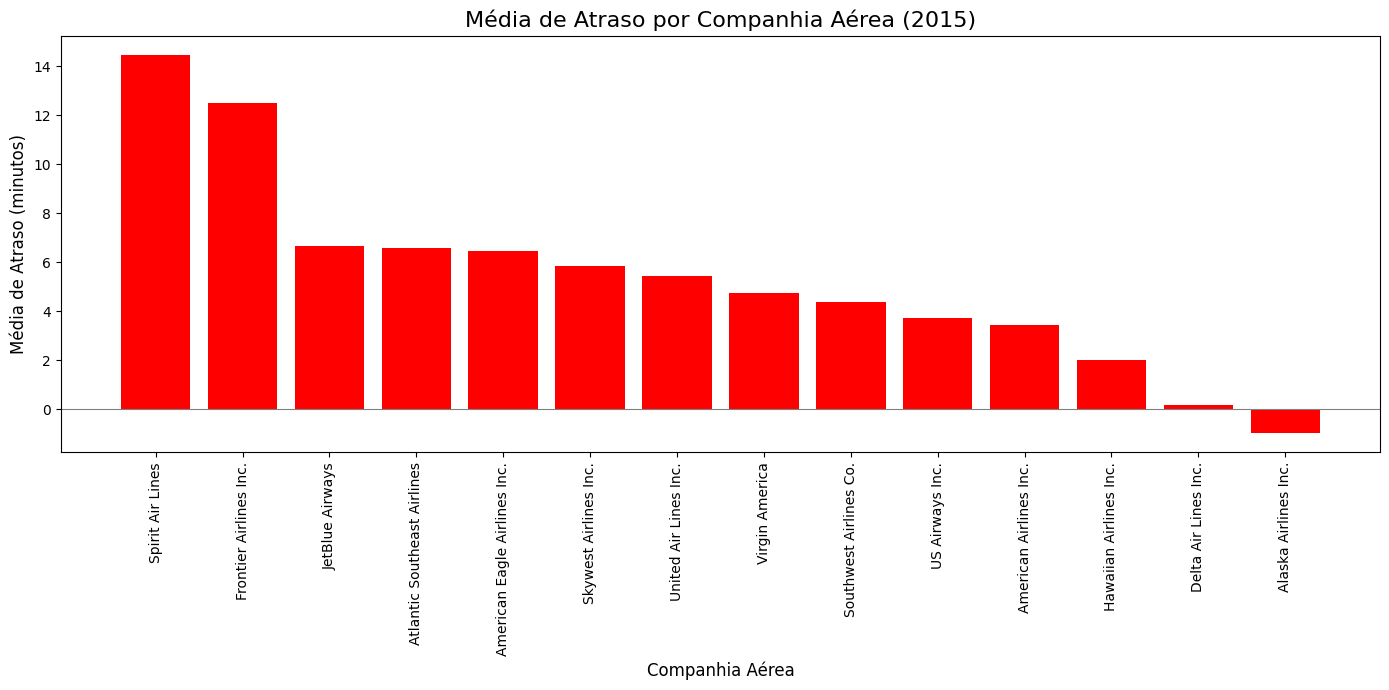

In [68]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, desc, round, col

# 1. Agrega os dados no PySpark (mesma lógica)
media_atrasos = df_flights.groupBy("AIRLINE") \
    .agg(
        round(avg("ARRIVAL_DELAY"), 2).alias("media_atraso_chegada")
    )

resultado_atrasos = media_atrasos.join(
        df_airlines,
        media_atrasos.AIRLINE == df_airlines.IATA_CODE
    ) \
    .orderBy(desc("media_atraso_chegada")) \
    .select(
        df_airlines.AIRLINE.alias("NOME_DA_COMPANHIA"),
        "media_atraso_chegada"
    )

# 2. Converte para Pandas
atrasos_cia_pandas = resultado_atrasos.toPandas()

# 3. Gera o gráfico de barras VERTICAIS
plt.figure(figsize=(14, 7))

# Trocado para plt.bar com a cor vermelho vivo
plt.bar(atrasos_cia_pandas['NOME_DA_COMPANHIA'], atrasos_cia_pandas['media_atraso_chegada'], color='red') # <-- COR ALTERADA AQUI

# Linha de referência horizontal
plt.axhline(0, color='grey', linewidth=0.8)

# Rótulos e Títulos
plt.title('Média de Atraso por Companhia Aérea (2015)', fontsize=16)
plt.ylabel('Média de Atraso (minutos)', fontsize=12)
plt.xlabel('Companhia Aérea', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('atraso_por_cia_vermelho_vivo.png')